In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img=cv2.imread("imori.jpg").astype(np.float32)
grayimg=cv2.imread("imori_gray.jpg").copy()

def Save(img,name):
    if cv2.imwrite(f"{name}.jpg",img):
        print("True")
        
def showhist(img,s):
    out=img.copy()
    plt.hist(out.ravel(),bins=255,range=(0,255),rwidth=0.8)
    plt.xlabel("value")
    plt.ylabel("nums")
    plt.savefig(f'{s}.png')
    plt.show()

In [4]:
def Affine_sharing(img,dx=0.,dy=0.):
    H,W,C=img.shape
    H_new=H+int(dy)
    W_new=W+int(dx)
    x=np.arange(W_new)
    y=np.arange(H_new)
    a=1.
    b=dx/H
    c=dy/W
    d=1.
    ab_cd=a*d-b*c
    xout,yout=np.meshgrid(x,y)
    
    xin=(d*xout-b*yout)/ab_cd
    yin=(-c*xout+a*yout)/ab_cd
    
    out=np.zeros((H_new,W_new,C))
    ind=np.where((xin<W)&(xin>=0)&(yin<H)&(yin>=0))
    tmp=img.copy()
    out[ind]=tmp[yin[ind].astype(np.int),xin[ind].astype(np.int)]
    
    out=out.astype(np.uint8)
    return out

In [5]:
ans1=img.copy()
ans1_1=Affine_sharing(ans1,dx=30)
Save(ans1_1,"ans1_1")
ans1_2=Affine_sharing(ans1,dy=30)
Save(ans1_2,"ans1_2")
ans1_3=Affine_sharing(ans1,dx=30,dy=30)
Save(ans1_3,"ans1_3")

True
True
True


In [2]:
def DFT(img):
    H,W,C=img.shape
    G=np.zeros_like(img,dtype=np.complex)
    indx=np.arange(W)
    indy=np.arange(H)
    x,y=np.meshgrid(indx,indy)
    
    for c in range(C):
        for k in range(W):
            for l in range(H):
                G[l,k,c]=np.sum(img[...,c]*np.exp(-2j*np.pi*(k*x/W+l*y/H)))
    G/=np.sqrt(H*W)
    
    return G

def IDFT(G):
    H,W,C=G.shape
    out=np.zeros_like(G,dtype=np.float32)
    indx=np.arange(W)
    indy=np.arange(H)
    k,l=np.meshgrid(indx,indy)
    
    for c in range(C):
        for  x in range(W):
            for y in range(H):
                out[y,x,c]=np.abs(np.sum(G[...,c]*np.exp(2j*np.pi*(k*x/W+l*y/H))))
    out/=np.sqrt(H*W)
    out = np.clip(out,0,255)
    out = out.astype(np.uint8)
    
    return out

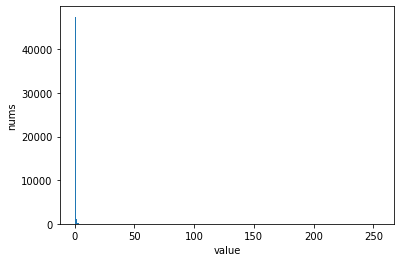

True


In [7]:
ans2=img.copy()
G=DFT(ans2.copy())
ps=(np.abs(G)/np.abs(G).max()*255).astype(np.uint8)
showhist(ps,"ans2pshist")
Save(ps,"ans2psimg")

In [8]:
ans2original=IDFT(G)
ans2original=(np.abs(ans2original)/np.abs(ans2original).max()*255).astype(np.uint8)
Save(ans2original,"ans2original")

True


In [9]:
def LowpassFilter(G,ratio=0.5):
    H,W,C = G.shape
    h_2=H//2
    w_2=W//2
    
    G_transformed=np.zeros_like(G,dtype=np.complex)
    G_transformed[:h_2,:w_2]=G[h_2:,w_2:]
    G_transformed[:h_2,w_2:]=G[h_2:,:w_2]
    G_transformed[h_2:,:w_2]=G[:h_2, w_2:]
    G_transformed[h_2:,w_2:]=G[:h_2,:w_2]
    
    x_=np.arange(W)
    y_=np.arange(H)
    xx,yy=np.meshgrid(x_,y_)
    x=xx-w_2
    y=yy-h_2
    r=np.sqrt(x*x+y*y)
    
    r_ind=np.where(r > (ratio*w_2),True,False)
    
    G_transformed[r_ind]=0.
    
    output=np.zeros_like(G,dtype=np.complex)
    output[:h_2,:w_2]=G_transformed[h_2:,w_2:]
    output[:h_2,w_2:]=G_transformed[h_2:,:w_2]
    output[h_2:,:w_2]=G_transformed[:h_2, w_2:]
    output[h_2:,w_2:]=G_transformed[:h_2,:w_2]
    
    return output

In [10]:
ans3=img.copy().astype(np.float32)
G=DFT(ans3)

In [11]:
g_lpf=LowpassFilter(G)
output=IDFT(g_lpf)
Save(output,"ans3")

True


In [12]:
def HighpassFilter(G,ratio=0.1):
    H,W,_=G.shape
    h_2=H//2
    w_2=W//2
    
    G_transformed=np.zeros_like(G,dtype=np.complex)
    G_transformed[:h_2,:w_2]=G[-h_2:,-w_2:]
    G_transformed[:h_2,w_2:]=G[-h_2:,:-w_2]
    G_transformed[h_2:,:w_2]=G[:-h_2, -w_2:]
    G_transformed[h_2:,w_2:]=G[:-h_2,:-w_2]
    
    x=np.arange(W)
    y=np.arange(H)
    xx,yy=np.meshgrid(x,y)
    x-=w_2
    y-=h_2
    r=np.sqrt(x**2+y**2)
    
    r_ind=np.where(r<(ratio*w_2),True,False)
    
    G_transformed[r_ind]=0.
    
    output=np.zeros_like(G,dtype=np.complex)
    output[:h_2,:w_2]=G_transformed[-h_2:,-w_2:]
    output[:h_2,w_2:]=G_transformed[-h_2:,:-w_2]
    output[h_2:,:w_2]=G_transformed[:-h_2, -w_2:]
    output[h_2:,w_2:]=G_transformed[:-h_2,:-w_2]
    
    return output

In [13]:
ans4=img.copy()
G=DFT(ans4)

In [14]:
g_hpf=HighpassFilter(G)
output=IDFT(g_hpf)
Save(output,"ans4")

True


In [23]:
def BandpassFilter(G,ratio1=0.1,ratio2=0.5):
    H,W,C = G.shape
    h_2=H//2
    w_2=W//2
    
    Gtransformed=np.zeros_like(G,dtype=np.complex)
    Gtransformed[:h_2,:w_2]=G[h_2:,w_2:]
    Gtransformed[:h_2,w_2:]=G[h_2:,:w_2]
    Gtransformed[h_2:,:w_2]=G[:h_2,:w_2]
    Gtransformed[h_2:,w_2:]=G[:h_2,:w_2]
    
    _x=np.arange(W)
    _y=np.arange(H)
    xx,yy=np.meshgrid(_x,_y)
    x=xx-w_2
    y=yy-h_2
    r=np.sqrt(x**2+y**2)
    
    #the places made 0 by bandpassfilter
    r_ind=np.where((r<(h_2*ratio1)) | (r>(h_2*ratio2)),True,False)
    Gtransformed[r_ind]=0.
    
    output=np.zeros_like(G,dtype=np.complex)
    output[:h_2,:w_2]=Gtransformed[h_2:,w_2:]
    output[:h_2,w_2:]=Gtransformed[h_2:,:w_2]
    output[h_2:,:w_2]=Gtransformed[:h_2,:w_2]
    output[h_2:,w_2:]=Gtransformed[:h_2,:w_2]
    
    return output

In [17]:
ans5=img.copy()
G=DFT(ans5)

In [24]:
G_bandpass=BandpassFilter(G)
output=IDFT(G_bandpass)
Save(output,"ans5")

True


In [3]:
def Cweight(u):
    if u==0:
        return 1./np.sqrt(2)
    else:
        return 1

def DCT(img, T=8):#T is kernel size
    H,W,C=img.shape
    
    F=np.zeros_like(img, dtype=np.float32)
    for c in range(C):
        for hcount in range(H//T):
            for wcount in range(W//T):
                for v in range(T):
                    for u in range(T):
                        F[v+hcount*T,u+wcount*T,c]=2/T*Cweight(u)*Cweight(v)
                        tmp=0.
                        for x in range(T):
                            for y in range(T):
                                tmp+=img[hcount*T+y,wcount*T+x,c]*np.cos(((2*x+1)*u*np.pi)/2./T)*np.cos(((2*y+1)*v*np.pi)/2./T)
                                
                        F[v+hcount*T,u+wcount*T,c]=F[v+hcount*T,u+wcount*T,c]*tmp
                        
    return F

def IDCT(F,T=8,K=8):#T is kernel size. K is valid kernel size.
    if K>T:
        print("valid kernel size error.")
        return False
    
    H,W,C=F.shape
    
    output=np.zeros_like(F,dtype=np.float32)
    for c in range(C):
        for hcount in range(H//T):
            for wcount in range(W//T):
                for y in range(T):
                    for x in range(T):
                        output[y+hcount*T,x+wcount*T,c]=2./T
                        tmp=0.
                        for u in range(K):
                            for v in range(K):
                                tmp+=Cweight(u)*Cweight(v)*F[v+hcount*T,u+wcount*T,c]*np.cos(((2*x+1)*u*np.pi)/2./T)*np.cos(((2*y+1)*v*np.pi)/2./T)
                        output[y+hcount*T,x+wcount*T,c]*=tmp
                        
    output = np.clip(output, 0, 255)
    output = np.round(output).astype(np.uint8)
    return output

In [23]:
ans6=img.copy()
dctimg=DCT(ans6)

In [29]:
output=IDCT(dctimg,K=8)
Save(output,"ans6")

True


In [4]:
def MSE(img1,img2):#mean squared error
    H,W,C=img1.shape
    mse = np.sum((img1-img2)**2)/(H*W*C)
    return mse

def PSNR(mse):#psnr is peak signal to noise ratio
    v_max=255
    psnr = 10 * np.log10(v_max**2 / mse)
    return psnr

def bitrate(K):#definition
    return 8.*K**2/(8.**2)

In [34]:
ans7=img.copy()
dctimg7=DCT(ans7.copy())

In [40]:
k=4
output=IDCT(dctimg7,K=k)
Save(output, f"ans7_k{k}")
mse=MSE(ans7, output)
if mse!=0:
    psnr=PSNR(mse)
    br=bitrate(k)
    print(f"MSE : {mse}, PSNR : {psnr}, BitRate : {br}")
else:
    print("two iamges are the same.")

True
MSE : 112.7452392578125, PSNR : 27.609821483020657, BitRate : 2.0


In [5]:
def quantizetion(F):
    T=8
    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
              (12, 12, 14, 19, 26, 58, 60, 55),
              (14, 13, 16, 24, 40, 57, 69, 56),
              (14, 17, 22, 29, 51, 87, 80, 62),
              (18, 22, 37, 56, 68, 109, 103, 77),
              (24, 35, 55, 64, 81, 104, 113, 92),
              (49, 64, 78, 87, 103, 121, 120, 101),
              (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    H,W,C=F.shape
    
    output=np.zeros_like(F,dtype=np.float32)
    for h in range(0,H,T):
        for w in range(0,W,T):
            for c in range(C):
                output[h:h+T,w:w+T,c]=np.round(F[h:h+T,w:w+T,c]/Q)*Q
    
    return output

In [54]:
ans8=img.copy()
dctimg8=DCT(ans8.copy())

In [56]:
k=8
quanted=quantizetion(dctimg8)
output=IDCT(quanted,K=k)
Save(output, f"ans8_k{k}")
mse=MSE(ans8, output)
if mse!=0:
    psnr=PSNR(mse)
    br=bitrate(k)
    print(f"MSE : {mse}, PSNR : {psnr}, BitRate : {br}")
else:
    print("two iamges are the same.")

True
MSE : 56.94281005859375, PSNR : 30.57641465622339, BitRate : 8.0


In [6]:
def RGB2YCbCr(img):
    output=np.zeros_like(img,dtype=np.float32)
    
    R=img[...,2]
    G=img[...,1]
    B=img[...,0]
    
    Y = 0.2990 * R + 0.5870 * G + 0.1140 * B
    Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128.
    Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128.
    
    output[...,2]=Y;output[...,1]=Cb;output[...,0]=Cr;
    return output

def YCbCr2RGB(img):
    output=np.zeros_like(img,dtype=np.float32)
    
    Y=img[...,2]
    Cb=img[...,1]
    Cr=img[...,0]
    
    R = Y + (Cr - 128.) * 1.4020
    G = Y - (Cb - 128.) * 0.3441 - (Cr - 128.) * 0.7139
    B = Y + (Cb - 128.) * 1.7718
    
    output[...,2]=R;output[...,1]=G;output[...,0]=B;
    output=np.clip(output,0,255)
    output=output.astype(np.uint8)
    
    return output

In [13]:
ans9=img.copy()
ycbcr_img=RGB2YCbCr(ans9)
ycbcr_img[...,2]*=0.7
output=YCbCr2RGB(ycbcr_img)
output = np.clip(output, 0, 255)
output = np.round(output).astype(np.uint8)
Save(output,"ans9")
print(MSE(ans9, output))

True
1741.0232747395833


In [7]:
def quantization_for_jpeg(F):
    T=8
    Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

    Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)
    H,W,C=F.shape
    
    output=np.zeros_like(F,dtype=np.float32)
    for h in range(0,H,T):
        for w in range(0,W,T):
            output[h:h+T,w:w+T,2]=np.round(F[h:h+T,w:w+T,2]/Q1)*Q1
    for h in range(0,H,T):
        for w in range(0,W,T):
            for c in range(2):
                output[h:h+T,w:w+T,c]=np.round(F[h:h+T,w:w+T,c]/Q2)*Q2
    
    return output

def JPEG(img):
    ycbcr=RGB2YCbCr(img)
    F=DCT(ycbcr)
    quanted=quantization_for_jpeg(F)
    rgb=IDCT(quanted)#(ycbcr_dct_quanted)
    processed_img=YCbCr2RGB(rgb)
    
    return processed_img

In [8]:
k=8
ans10=img.copy()
output=JPEG(ans10.copy())
Save(output, f"ans10jpeg_k{k}")
mse=MSE(ans10, output)
if mse!=0:
    psnr=PSNR(mse)
    br=bitrate(k)
    print(f"MSE : {mse}, PSNR : {psnr}, BitRate : {br}")
else:
    print("two iamges are the same.")

True
MSE : 73.28336588541667, PSNR : 29.480749527204942, BitRate : 8.0
